In [ ]:
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import KeyedVectors, Word2Vec
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from torch import optim
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_to_ind = {}
class_to_ind["padding"] = 0
x = 1
classes = ['ORG', 'OTHER_PERSON', 'WITNESS', 'GPE', 'STATUTE', 'DATE', 'PROVISION', 'COURT', 'PRECEDENT', 'CASE_NUMBER', 'PETITIONER', 'JUDGE', 'RESPONDENT']
for i in ["B_", "I_"]:
    for j in classes:
        class_to_ind[i+j] = x
        x += 1
class_to_ind["O"] = x
print(class_to_ind)

{'padding': 0, 'B_ORG': 1, 'B_OTHER_PERSON': 2, 'B_WITNESS': 3, 'B_GPE': 4, 'B_STATUTE': 5, 'B_DATE': 6, 'B_PROVISION': 7, 'B_COURT': 8, 'B_PRECEDENT': 9, 'B_CASE_NUMBER': 10, 'B_PETITIONER': 11, 'B_JUDGE': 12, 'B_RESPONDENT': 13, 'I_ORG': 14, 'I_OTHER_PERSON': 15, 'I_WITNESS': 16, 'I_GPE': 17, 'I_STATUTE': 18, 'I_DATE': 19, 'I_PROVISION': 20, 'I_COURT': 21, 'I_PRECEDENT': 22, 'I_CASE_NUMBER': 23, 'I_PETITIONER': 24, 'I_JUDGE': 25, 'I_RESPONDENT': 26, 'O': 27}


In [ ]:
with open("/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/NER_TRAIN_JUDGEMENT.json") as f:
    data = json.load(f)
with open("/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/NER_TEST_JUDGEMENT.json") as f:
    test_data = json.load(f)

y = []
for d in data:
    ls_temp = []
    c = 0
    for dd in d["annotations"][0]["result"]:
        if dd["value"]["labels"][0] not in ls_temp:
            ls_temp.append(dd["value"]["labels"][0])
            c += 1
    if c == 0:
        ls_temp.append("Empty")
    ls_temp.sort()
    y.append(ls_temp)

ls_to_int = []
for i in y:
    ls_to_int.append(i)
freq = {}
for i in y:
    if ls_to_int.index(i) in freq:
        freq[ls_to_int.index(i)] += 1
    else:
        freq[ls_to_int.index(i)] = 1
ls_1 = []
for i in freq:
    if freq[i] == 1:
        ls_1.append(ls_to_int[i])
for i in ls_1:
    y[y.index(i)] = ["Mixed"]

y = MultiLabelBinarizer().fit_transform(y)
data_train, data_val = train_test_split(data, test_size=0.15, stratify=y, random_state=10)

end_chars = ['ORG', 'SON', 'ESS', 'GPE', 'UTE', 'ATE', 'ION', 'URT', 'ENT',
             'BER', 'NER', 'DGE', 'ENT', 'ORG', 'SON', 'ESS', 'GPE', 'UTE', 'ATE', 'ION', 'URT', 'ENT', 'BER', 'NER', 'DGE', 'ENT']
stuff_to_remove = [",", ".", "?", ")", ";", "'", '"', ":", 'a', 'b', 'c', 'd', 'e',
                   'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
                   's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '/', ']', '}', '(', "’",
                   '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
stuff_to_remove2 = [",", "?", ")", ";", "'", '"', ":", 'a', 'b', 'c', 'd', 'e',
                   'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
                   's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '/', ']', '}', '-']
def chunking(dat):
    new_data = {}
    for i in dat:
        curr_id = i["id"]
        st_end = i["annotations"][0]["result"]
        label_sent = i["data"]["text"]
        diff = 0
        for se in st_end:
            start = se["value"]["start"]
            if (start-1) >= 0 and label_sent[start-1] != " ":
                i["data"]["text"] = label_sent[:start-1] + " "+label_sent[start:]
        i["data"]["text"] = i["data"]["text"].replace("\n", " ")
        i["data"]["text"] = i["data"]["text"].replace("\t", " ")
        label_sent = i["data"]["text"]
        for se in st_end:
            start = se["value"]["start"]
            end = se["value"]["end"]
            start += diff
            end += diff
            curr_chunk = label_sent[start: end]
            org_len = len(curr_chunk)
            curr_chunk = curr_chunk.split(" ")
            add_chunk = ""
            for cc in range(len(curr_chunk)):
                if cc == 0:
                    add_chunk += "B_"+se["value"]["labels"][0]
                else:
                    add_chunk += " I_"+se["value"]["labels"][0]
            diff += (len(add_chunk)-org_len)
            label_sent = label_sent[0:start] + add_chunk + label_sent[end:]
        '''print(i["annotations"][0]["result"])
        print(i["data"])
        print(label_sent)
        print()'''
        new_label = []
        for ele in label_sent.split(" "):
            if ele[:2] == "B_" or ele[:2] == "I_":
                while ele[-1] in stuff_to_remove:
                    ele = ele[:-1]
                if ele[-2:] == "'s":
                    ele = ele[:-2]
                for el2 in range(len(ele)):
                    if ele[el2] in stuff_to_remove2:
                        ele = ele[:el2]
                        break
                new_label.append(ele)
            else:
                new_label.append("O")
        new_data[curr_id] = {
            "text": i["data"]["text"].lower(),
            "labels": new_label
        }
    return new_data

train_data = chunking(data_train)
val_data = chunking(data_val)
test_data = chunking(test_data)

errors_train = []
errors_val = []
errors_test = []
for i in train_data:
    for j in train_data[i]["labels"]:
        if j not in class_to_ind:
            errors_train.append(i)
for i in val_data:
    for j in val_data[i]["labels"]:
        if j not in class_to_ind:
            errors_val.append(i)
for i in test_data:
    for j in test_data[i]["labels"]:
        if j not in class_to_ind:
            errors_test.append(i)
for x in errors_train:
    try:
        del train_data[x]
    except:
        pass
for x in errors_val:
    try:
        del val_data[x]
    except:
        pass
for x in errors_test:
    try:
        del test_data[x]
    except:
        pass

In [ ]:
# Saving the new data files
with open("/content/train_data.json", "w") as file:
    json.dump(train_data, file)
with open("/content/test_data.json", "w") as file:
    json.dump(test_data, file)
with open("/content/val_data.json", "w") as file:
    json.dump(val_data, file)

In [ ]:
curr_vocab = []
for i in train_data:
    for j in train_data[i]["text"].split(" "):
        curr_vocab.append(j)
for i in val_data:
    for j in val_data[i]["text"].split(" "):
        curr_vocab.append(j)
for i in test_data:
    for j in test_data[i]["text"].split(" "):
        curr_vocab.append(j)

In [ ]:
max_len = -1
for i in train_data:
    max_len = max(len(train_data[i]["text"].split(" ")), max_len)
for i in val_data:
    max_len = max(len(val_data[i]["text"].split(" ")), max_len)
for i in test_data:
    max_len = max(len(test_data[i]["text"].split(" ")), max_len)
print("Maximum Length of Sentence in Data:", max_len)

Maximum Length of Sentence in Data: 566


# **Word2Vec**

In [ ]:
w2vec_keyed_vector = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# Generating Embedding Matrix
emb_vocab = w2vec_keyed_vector.index_to_key
ind = 0
word_to_ind = {}
embedding_matrix = torch.zeros(len(curr_vocab), 300)
for word in curr_vocab:
    word_to_ind[word] = ind
    if word in emb_vocab:
        embedding_matrix[ind] = torch.tensor(w2vec_keyed_vector[word])
    else:
        embedding_matrix[ind] = torch.rand(300)
    ind += 1
torch.save(embedding_matrix, '/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/embedding_matrix.pt')
with open("/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/word_to_ind.json", "w") as file:
    json.dump(word_to_ind, file)

In [ ]:
# Loading embedding Matrix
word2vec_embedding_matrix = torch.load('/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/embedding_matrix.pt')
with open("/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/word_to_ind.json") as file:
    word2vec_word_to_ind = json.load(file)

# **Glove**

In [ ]:
! unzip "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/glove.42B.300d.zip"

Archive:  /content/drive/MyDrive/Colab_data/NLP_AS2/Task1/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
emb_vocab = []
glove_embeddings = {}
with open("/content/glove.42B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        emb_vocab.append(word)
        vector = np.asarray(values[1:], "float32")
        glove_embeddings[word] = vector

In [ ]:
# Generating Embedding Matrix
ind = 0
word_to_ind = {}
embedding_matrix = torch.zeros(len(curr_vocab), 300)
for word in curr_vocab:
    word_to_ind[word] = ind
    if word in emb_vocab:
        embedding_matrix[ind] = torch.tensor(glove_embeddings[word])
    else:
        embedding_matrix[ind] = torch.rand(300)
    ind += 1
torch.save(embedding_matrix, '/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/glove_embedding_matrix.pt')
with open("/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/glove_word_to_ind.json", "w") as file:
    json.dump(word_to_ind, file)

In [ ]:
# Loading embedding Matrix
glove_embedding_matrix = torch.load('/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/glove_embedding_matrix.pt')
with open("/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/glove_word_to_ind.json") as file:
    glove_word_to_ind = json.load(file)

# **Fasttext**

In [ ]:
# Loading embedding Matrix
fasttext_embedding_matrix = torch.load('/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/fasttext_embedding_matrix.pt')
with open("/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/fasttext_word_to_ind.json") as file:
    fasttext_word_to_ind = json.load(file)

# **DL Models**

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, _input_size, _hidden_size, output_size, emb, word2ind):
        super().__init__()
        self.word_to_ind = word2ind
        self.hidden_size = _hidden_size
        self.embeddings = nn.Embedding.from_pretrained(emb)
        self.rnn_layer = nn.RNN(input_size=_input_size, hidden_size=_hidden_size,
                                num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(_hidden_size, output_size)

    # Inputs: [[of length 300], [], ..... number of words(space separated) in sentence]
    def forward(self, inputs):
        input_vec = torch.zeros(self.hidden_size, 300)
        ind = 0
        for inp in inputs:
            input_vec[ind] = self.embeddings(torch.tensor(self.word_to_ind[inp]))
            ind += 1
        input_vec = input_vec.unsqueeze(0)
        out, h_n = self.rnn_layer(input_vec)
        output = self.linear1(out)
        return output

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, _input_size, _hidden_size, output_size, emb, word2ind):
        super().__init__()
        self.hidden_size = _hidden_size
        self.word_to_ind = word2ind
        self.embeddings = nn.Embedding.from_pretrained(emb)
        self.rnn_layer = nn.LSTM(input_size=_input_size, hidden_size=_hidden_size,
                                num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(_hidden_size, output_size)

    # Inputs: [[of length 300], [], ..... number of words(space separated) in sentence]
    def forward(self, inputs):
        input_vec = torch.zeros(self.hidden_size, 300)
        ind = 0
        for inp in inputs:
            input_vec[ind] = self.embeddings(torch.tensor(self.word_to_ind[inp]))
            ind += 1
        input_vec = input_vec.unsqueeze(0)
        out, h_n = self.rnn_layer(input_vec)
        output = self.linear1(out)
        return output

In [ ]:
class GRU_model(nn.Module):
    def __init__(self, _input_size, _hidden_size, output_size, emb, word2ind):
        super().__init__()
        self.hidden_size = _hidden_size
        self.word_to_ind = word2ind
        self.embeddings = nn.Embedding.from_pretrained(emb)
        self.rnn_layer = nn.GRU(input_size=_input_size, hidden_size=_hidden_size,
                                num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(_hidden_size, output_size)

    # Inputs: [[of length 300], [], ..... number of words(space separated) in sentence]
    def forward(self, inputs):
        input_vec = torch.zeros(self.hidden_size, 300)
        ind = 0
        for inp in inputs:
            input_vec[ind] = self.embeddings(torch.tensor(self.word_to_ind[inp]))
            ind += 1
        input_vec = input_vec.unsqueeze(0)
        out, h_n = self.rnn_layer(input_vec)
        output = self.linear1(out)
        return output

# **Train/Test**

In [ ]:
def train(model, epochs, loss_fxn, optimizer, model_name):
    no_seen = 0
    no_batch = 0
    no_batch1 = 0
    for ep in tqdm(range(epochs)):
        model.train()
        train_loss, train_acc = 0, 0
        ground_truth_tr = []
        pred_labels_tr = []
        data_train = ([(k, v) for k, v in train_data.items()])
        random.shuffle(data_train)
        for key, value in data_train:
            no_batch += 1
            X = value["text"].split(" ")
            _y = value["labels"]
            y_pred = model(X)[0][:len(_y)]
            no_seen += len(X)

            y = torch.zeros(len(_y))
            for i in range(len(_y)):
                y[i] = class_to_ind[_y[i]]

            y = y.type('torch.LongTensor')
            loss = loss_fxn(y_pred, y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            for lab in range(len(_y)):
                ground_truth_tr.append(class_to_ind[_y[lab]])
                pred_labels_tr.append(y_pred_class[lab])
            #train_acc = (y_pred_class == y).sum().item()/len(y_pred)
        print("Train f1_score:", f1_score(ground_truth_tr, pred_labels_tr, average='macro'))
        torch.save({'epoch': ep,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()}, '/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/glove/'+model_name+str(ep+5)+'.pth')


def test(model, loss_fxn):
    model.eval()
    test_acc, n = 0, 0
    ground_truth_te = []
    pred_prob = []
    pred_labels_te = []
    with torch.inference_mode():
        for i in test_data:
            X = test_data[i]["text"].split(" ")
            _y = test_data[i]["labels"]
            test_pred = model(X)[0][:len(_y)]
            #pred_prob.append(test_pred)
            y = torch.zeros(len(_y))
            for i in range(len(_y)):
                y[i] = class_to_ind[_y[i]]
            y = y.type('torch.LongTensor')
            y_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            for lab in range(len(_y)):
                ground_truth_te.append(class_to_ind[_y[lab]])
                pred_labels_te.append(y_pred_class[lab])
            n += 1
            test_acc += ((y_pred_class == y).sum().item()/len(y_pred_class))
        test_acc = test_acc/n
    print("Test Accuracy:", test_acc, "\nTest F1-Score:", f1_score(ground_truth_te, pred_labels_te, average='macro'))

In [ ]:
def load_model(model, optim, file_name):
    checkpoint = torch.load(file_name)
    model.load_state_dict(checkpoint["model_state_dict"])
    optim.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["epoch"]

# **Model Training/Testing**

In [ ]:
model_1 = RNN_model(300, 566, 28, embedding_matrix, word2vec_word_to_ind)
loss_fxn_1 = nn.CrossEntropyLoss()
optimizer_1 =  optim.Adam(model_1.parameters())
train(model_1, 5, loss_fxn_1, optimizer_1, 'model_rnn_ep_')

  0%|          | 0/5 [00:00<?, ?it/s]

Train f1_score: 0.3264875980405723
Train f1_score: 0.38527200180741294
Train f1_score: 0.39287811734997163
Train f1_score: 0.39651663412107685
Train f1_score: 0.38688068576200246


In [ ]:
# Using saved model
model_1 = RNN_model(300, 566, 28, embedding_matrix, word2vec_word_to_ind)
optimizer_1 =  optim.Adam(model_1.parameters())
loss_fxn_1 = nn.CrossEntropyLoss()
file_na = '/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/glove/glovemodel_rnn_ep_4.pth'
load_model(model_1, optimizer_1, file_na)
train(model_1, 5, loss_fxn_1, optimizer_1, 'glovemodel_rnn_ep_')

  0%|          | 0/5 [00:00<?, ?it/s]

Train f1_score: 0.38453048812046936
Train f1_score: 0.3838004818788779
Train f1_score: 0.37761603479732875
Train f1_score: 0.3693165987256794
Train f1_score: 0.36347084827697124


# **Generating Graphs**

In [ ]:
def generate_graph(model, saved_model, no_epochs, loss_fxn, optim, diff):
    val_accuracy_ep = []
    val_loss_ep = []
    val_f1_ep = []
    train_accuracy_ep = []
    train_loss_ep = []
    train_f1_ep = []
    ep_ls = []
    for ep in range(no_epochs):
        ep_ls.append(ep+1)
        curr_model = saved_model + str(ep+diff) + ".pth"
        load_model(model, optim, curr_model)
        model.eval()

        ground_truth_train = []
        pred_labels_train = []
        train_loss, train_acc, n_val = 0, 0, 0
        with torch.inference_mode():
            data_train = ([(k, v) for k, v in train_data.items()])
            #random.shuffle(data_train)
            data_train = data_train[:len(data_train)//10]
            for key, value in data_train:
                X = value["text"].split(" ")
                _y = value["labels"]
                train_pred = model(X)[0][:len(_y)]
                y = torch.zeros(len(_y))
                for i in range(len(_y)):
                    y[i] = class_to_ind[_y[i]]
                y = y.type('torch.LongTensor')
                train_loss += loss_fxn(train_pred, y)
                n_val += 1
                train_pred_labels = torch.argmax(torch.softmax(train_pred, dim=1), dim=1)
                train_acc += ((train_pred_labels == y).sum().item()/len(train_pred_labels))
                for lab in range(len(_y)):
                    ground_truth_train.append(class_to_ind[_y[lab]])
                    pred_labels_train.append(train_pred_labels[lab])
        train_loss = train_loss/n_val
        train_acc = train_acc/n_val
        train_f1 = f1_score(ground_truth_train, pred_labels_train, average='macro')
        train_accuracy_ep.append(train_acc)
        train_loss_ep.append(train_loss)
        train_f1_ep.append(train_f1)

        ground_truth_val = []
        pred_labels_val = []
        val_loss, val_acc, n_val = 0, 0, 0
        with torch.inference_mode():
            data_val = ([(k, v) for k, v in val_data.items()])
            #random.shuffle(data_train)
            for key, value in data_val:
                X = value["text"].split(" ")
                _y = value["labels"]
                val_pred = model(X)[0][:len(_y)]
                y = torch.zeros(len(_y))
                for i in range(len(_y)):
                    y[i] = class_to_ind[_y[i]]
                y = y.type('torch.LongTensor')
                val_loss += loss_fxn(val_pred, y)
                n_val += 1
                val_pred_labels = torch.argmax(torch.softmax(val_pred, dim=1), dim=1)
                val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))
                for lab in range(len(_y)):
                    ground_truth_val.append(class_to_ind[_y[lab]])
                    pred_labels_val.append(val_pred_labels[lab])
        val_loss = val_loss/n_val
        val_acc = val_acc/n_val
        val_f1 = f1_score(ground_truth_val, pred_labels_val, average='macro')
        val_accuracy_ep.append(val_acc)
        val_loss_ep.append(val_loss)
        val_f1_ep.append(val_f1)

    plt.plot(ep_ls, val_loss_ep)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.show()

    plt.plot(ep_ls, val_f1_ep)
    plt.xlabel("Epochs")
    plt.ylabel("Validation F1 Score")
    plt.show()

    plt.plot(ep_ls, val_accuracy_ep)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.show()

    plt.plot(ep_ls, train_loss_ep)
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss")
    plt.show()

    plt.plot(ep_ls, train_f1_ep)
    plt.xlabel("Epochs")
    plt.ylabel("Train F1 Score")
    plt.show()

    plt.plot(ep_ls, train_accuracy_ep)
    plt.xlabel("Epochs")
    plt.ylabel("Train Accuracy")
    plt.show()

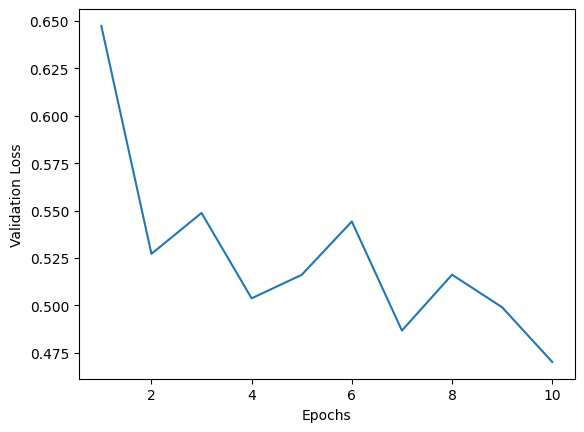

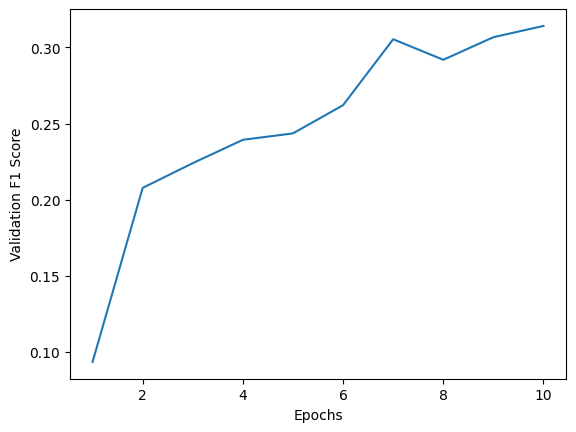

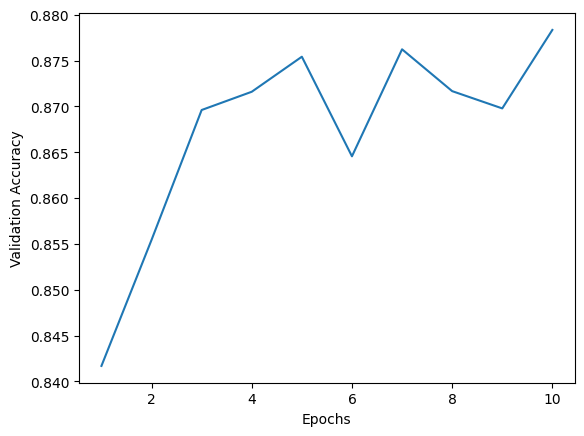

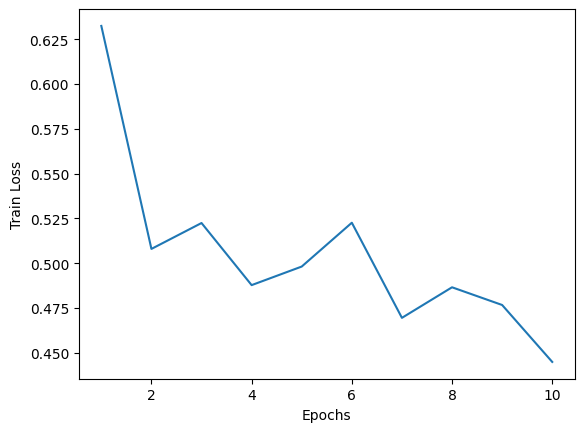

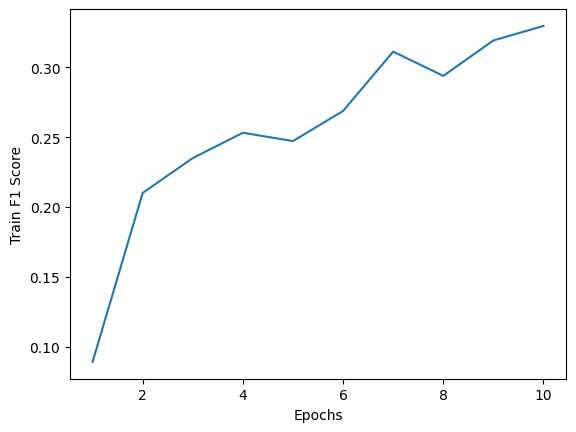

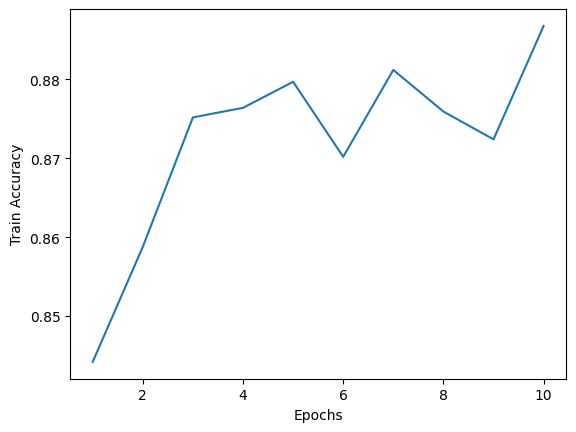

In [ ]:
# RNN with Word2Vec
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/model_1_ep_"
model = RNN_model(300, 566, 28, word2vec_embedding_matrix, word2vec_word_to_ind)
generate_graph(model, sm_name, 10, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 0)

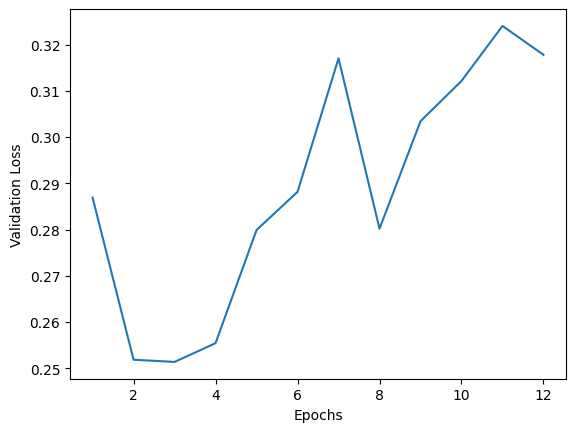

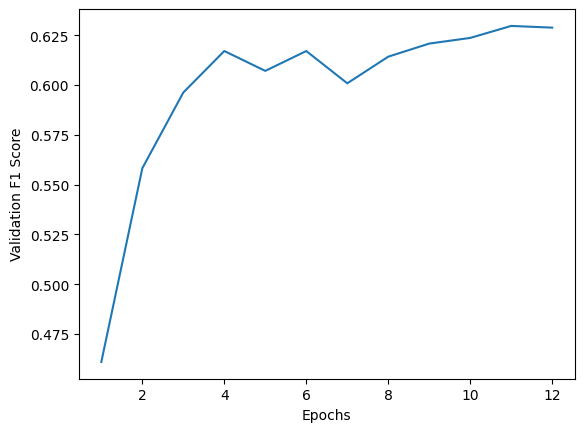

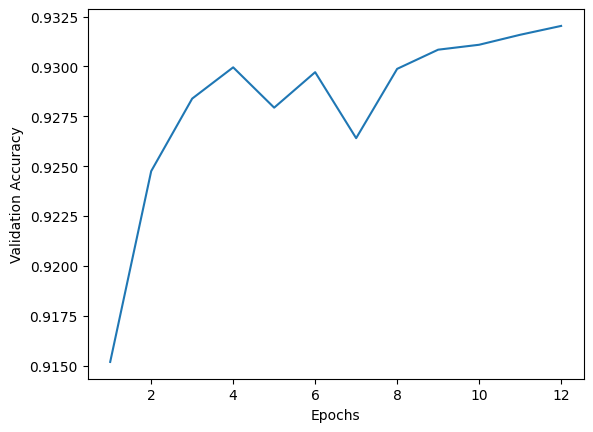

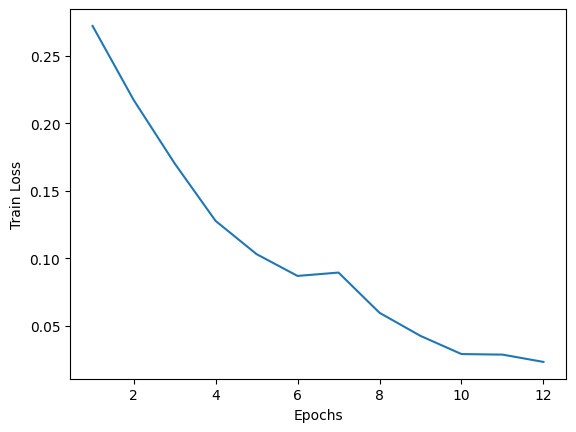

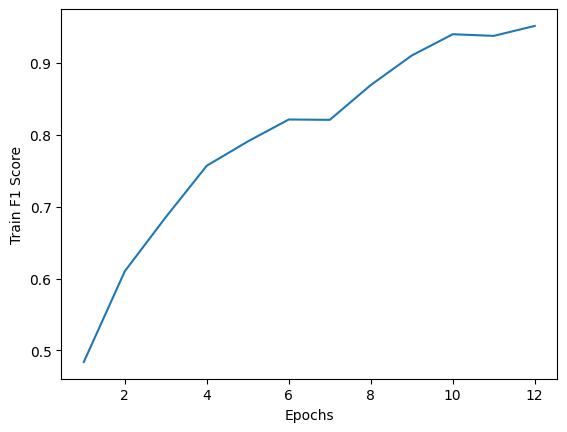

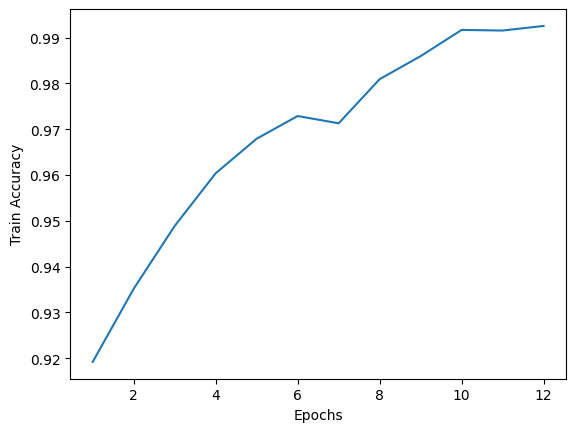

In [ ]:
# LSTM with Word2Vec
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/model_task1_lstm_ep_"
model = LSTM_model(300, 566, 28, word2vec_embedding_matrix, word2vec_word_to_ind)
generate_graph(model, sm_name, 12, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 1)

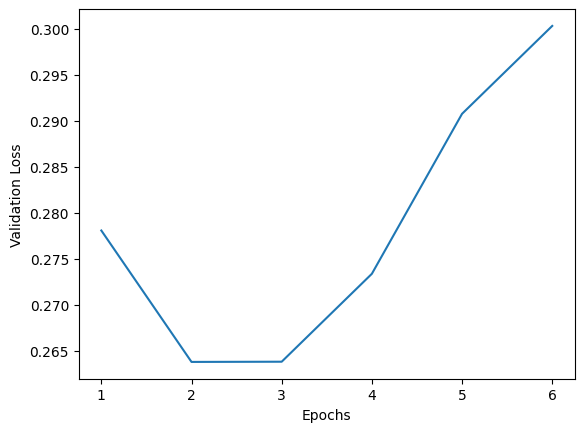

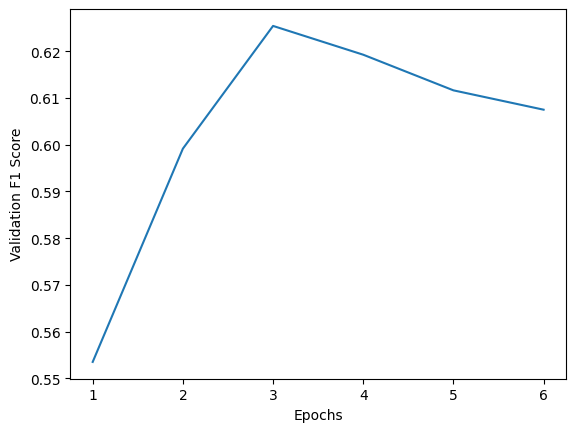

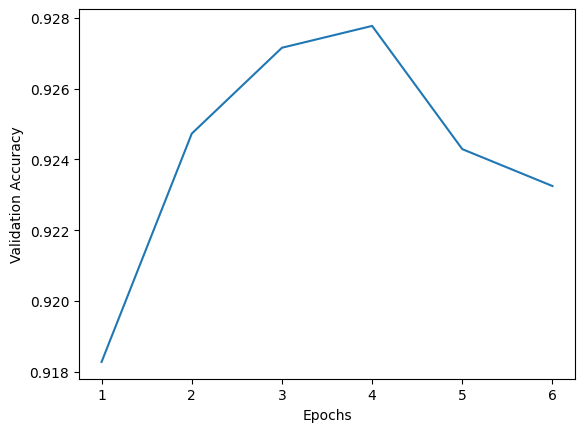

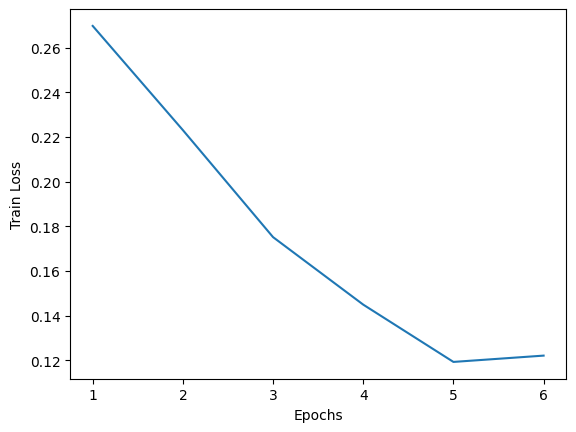

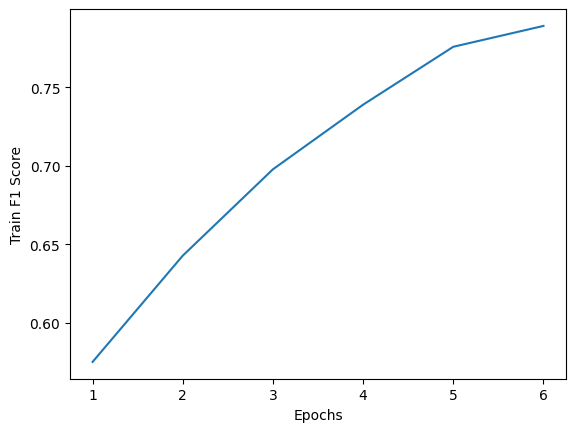

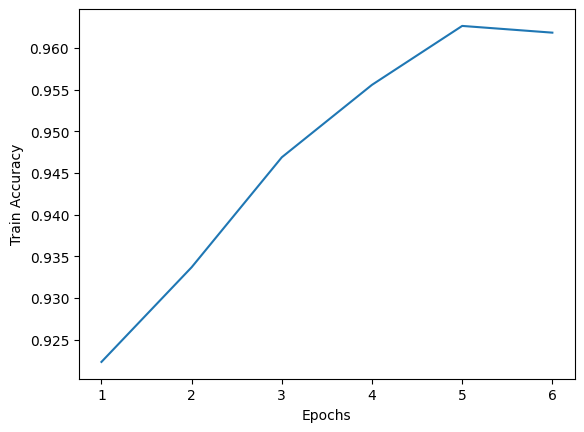

In [ ]:
# GRU with Word2Vec
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/model_task1_gru_ep_"
model = GRU_model(300, 566, 28, word2vec_embedding_matrix, word2vec_word_to_ind)
generate_graph(model, sm_name, 6, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 1)

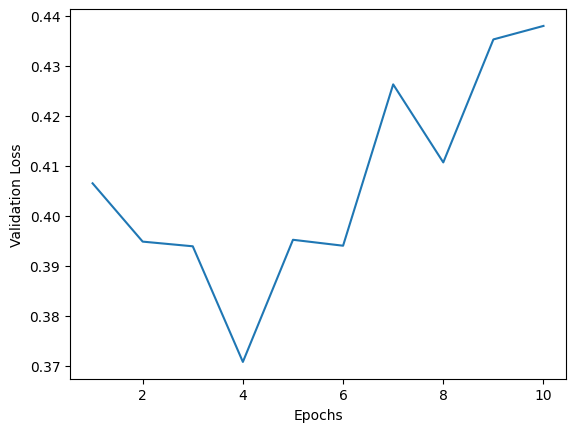

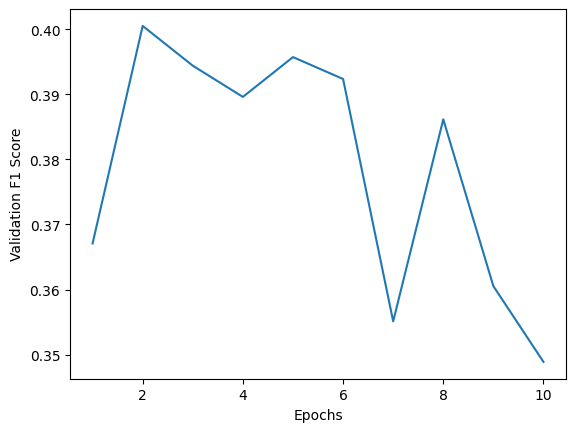

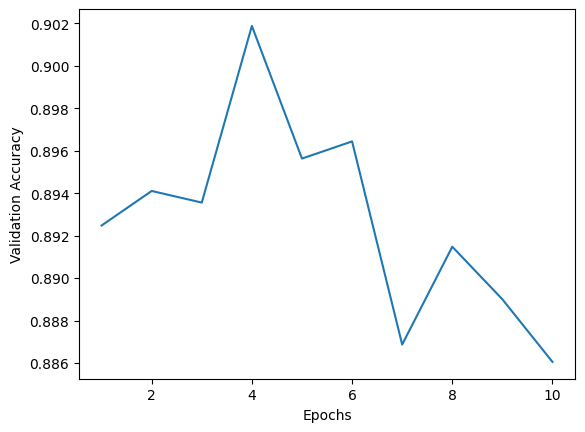

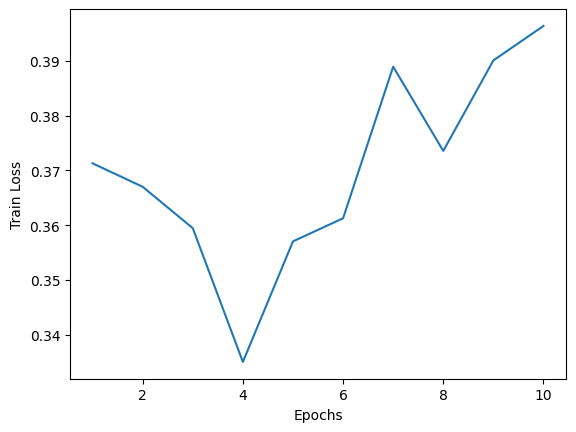

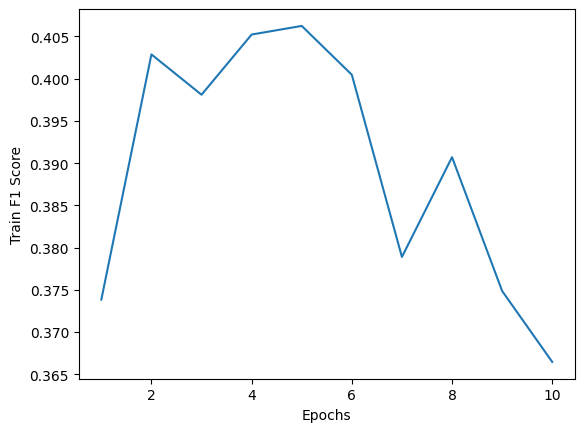

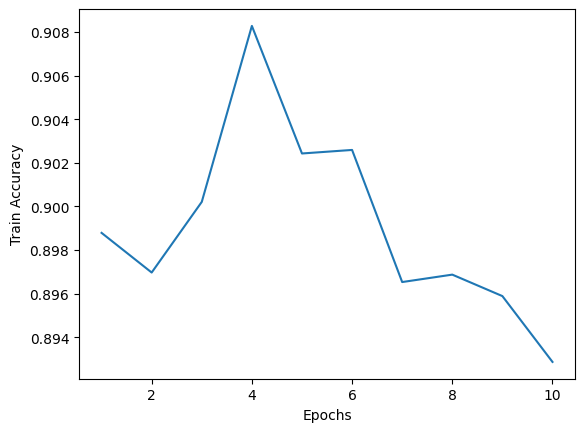

In [ ]:
# RNN with glove
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/glove/glovemodel_rnn_ep_"
model = RNN_model(300, 566, 28, glove_embedding_matrix, glove_word_to_ind)
generate_graph(model, sm_name, 10, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 0)

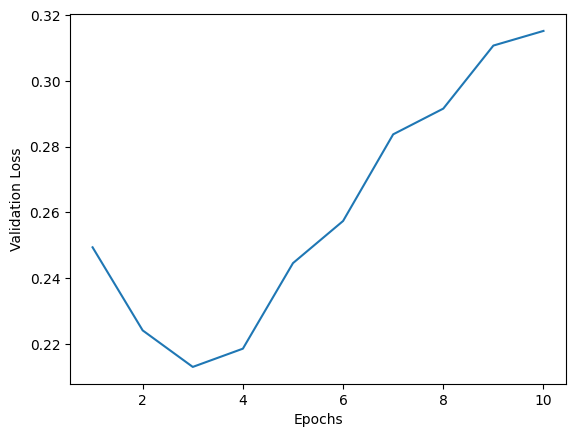

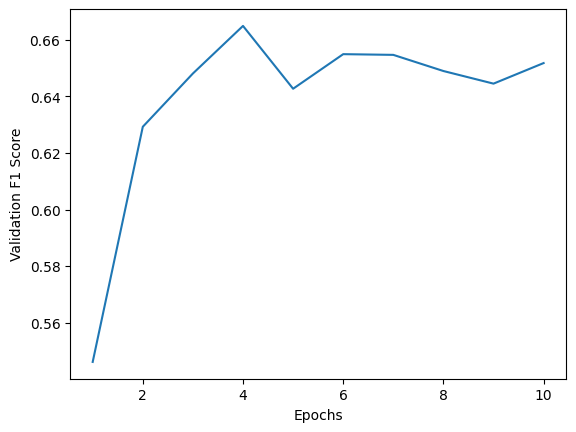

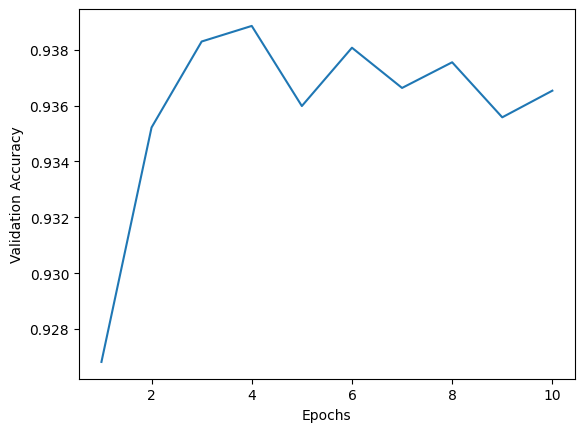

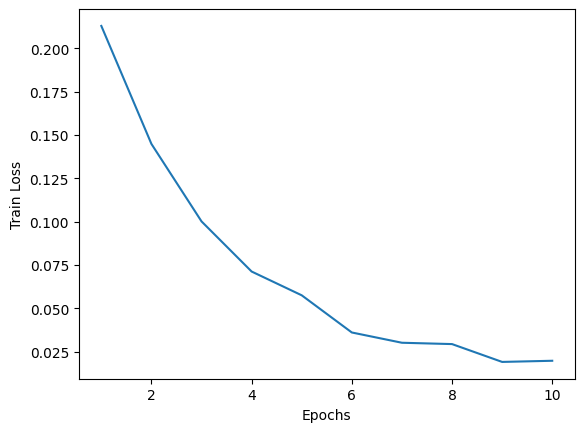

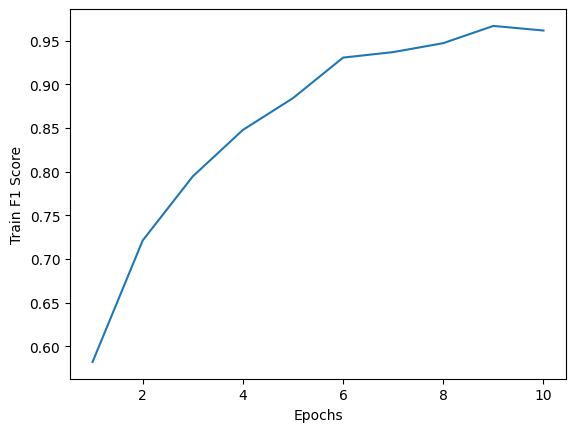

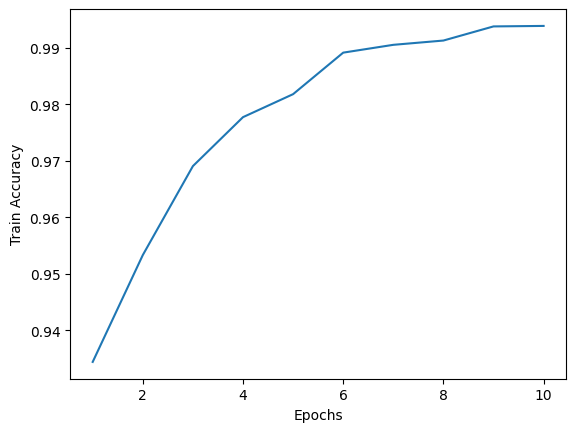

In [ ]:
# LSTM with glove
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/glove/model_task1_lstm_glove_ep_"
model = LSTM_model(300, 566, 28, glove_embedding_matrix, glove_word_to_ind)
generate_graph(model, sm_name, 10, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 0)

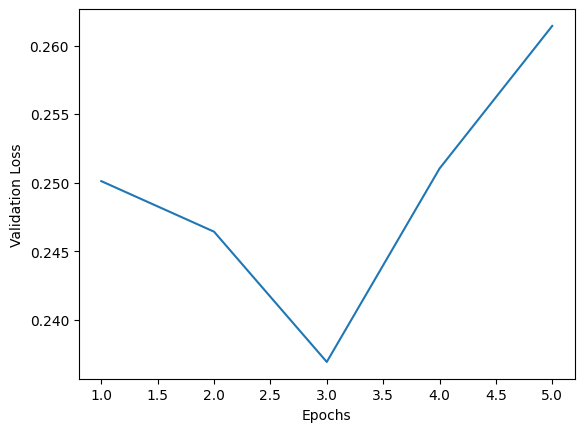

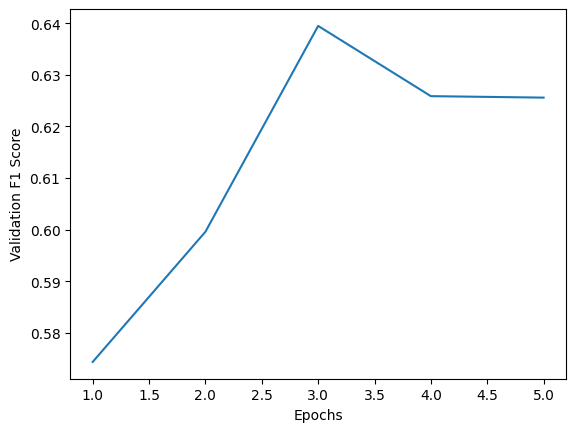

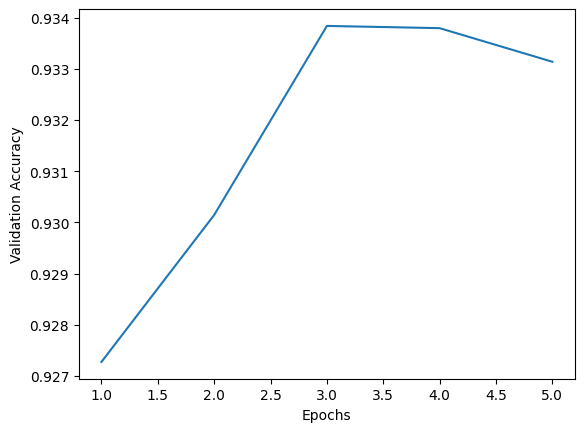

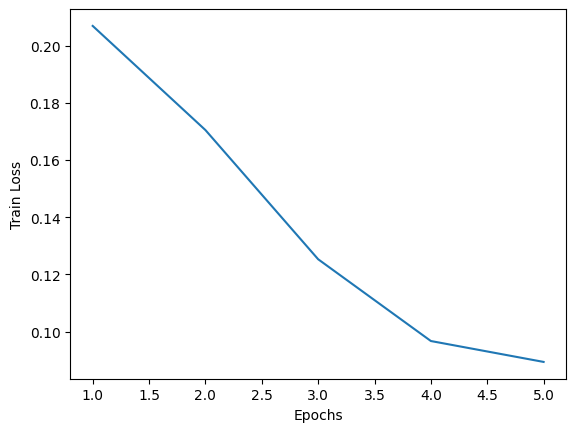

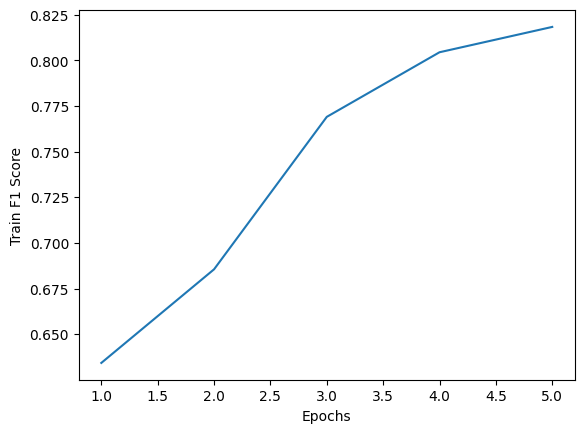

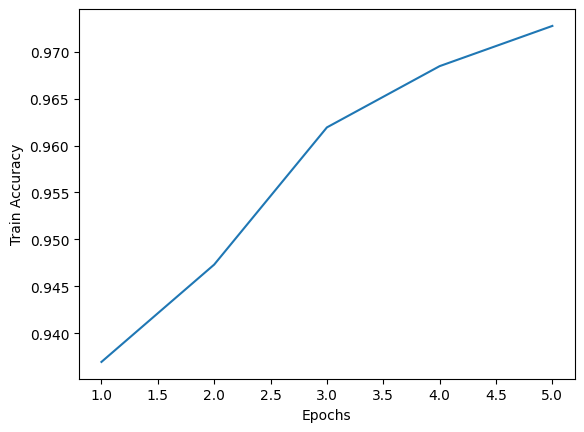

In [ ]:
# GRU with glove
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/shared/t1_glovemodel_task1_gru_glove_ep_"
model = GRU_model(300, 566, 28, glove_embedding_matrix, glove_word_to_ind)
generate_graph(model, sm_name, 5, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 0)

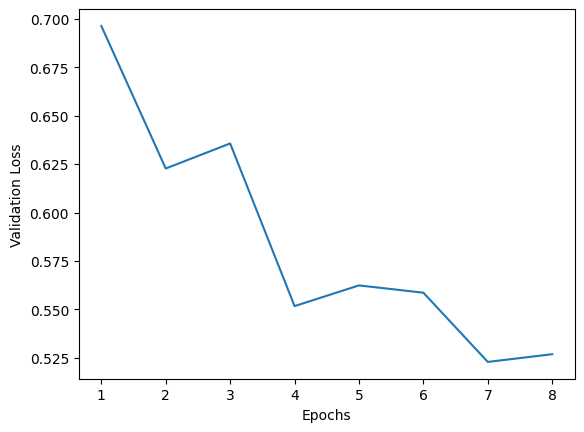

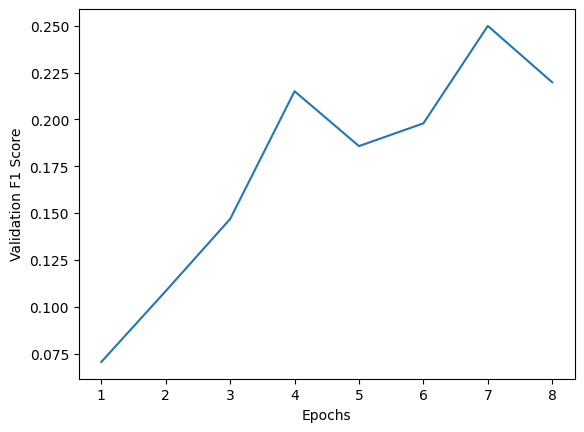

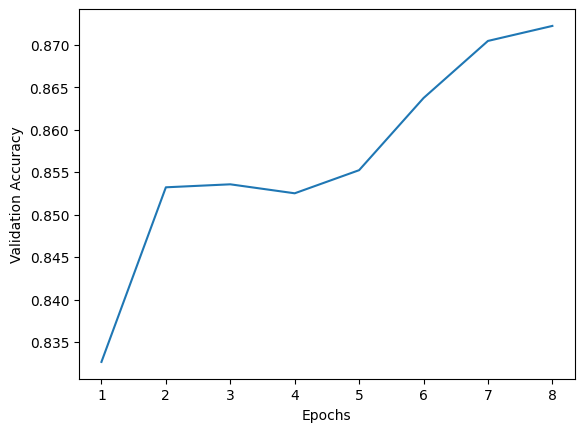

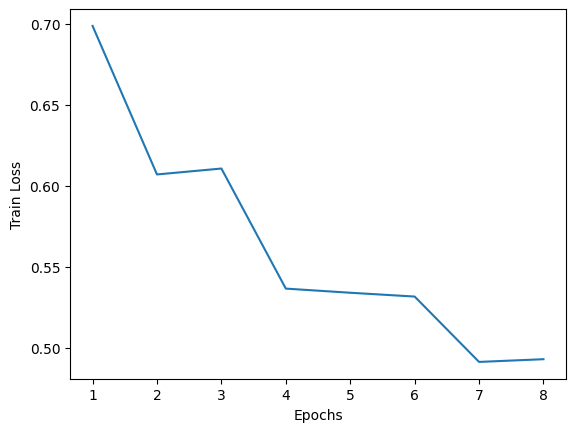

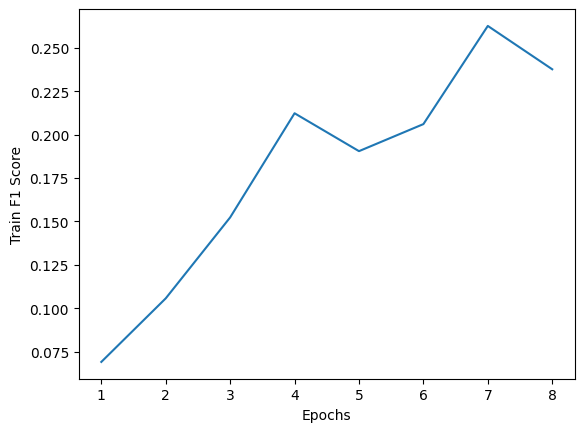

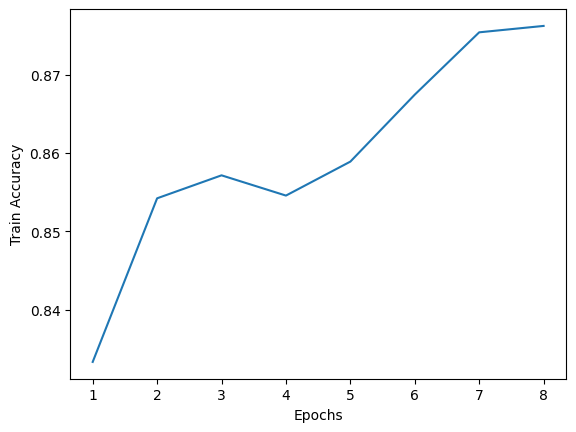

In [ ]:
# RNN with fasttext
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/shared/model_rnn_fasttext_ep_"
model = RNN_model(300, 566, 28, fasttext_embedding_matrix, fasttext_word_to_ind)
generate_graph(model, sm_name, 8, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 0)

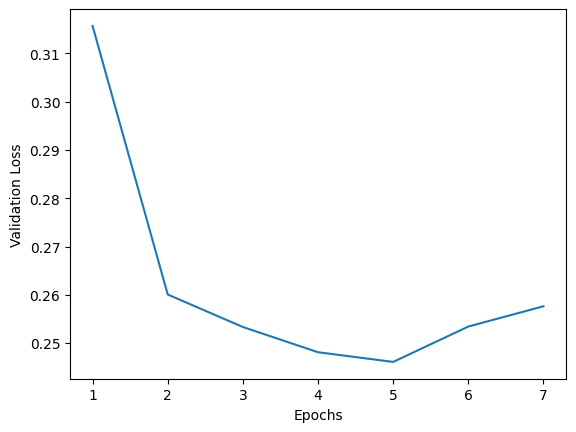

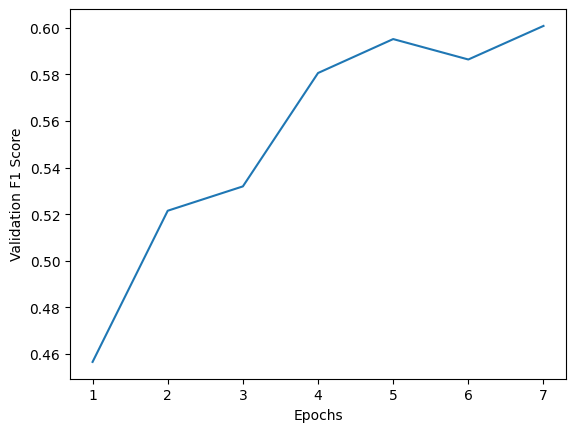

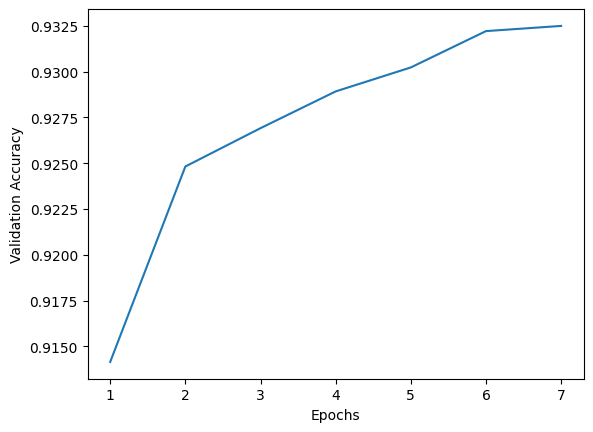

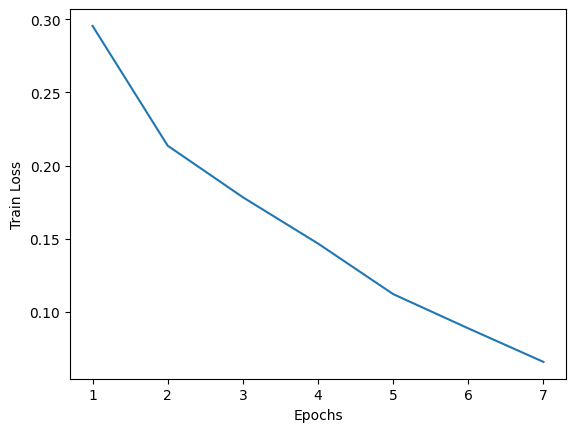

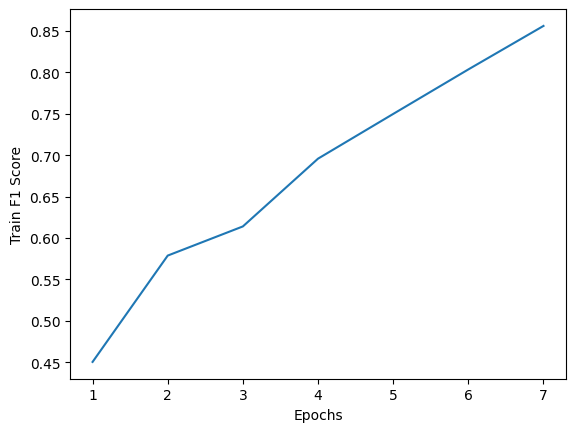

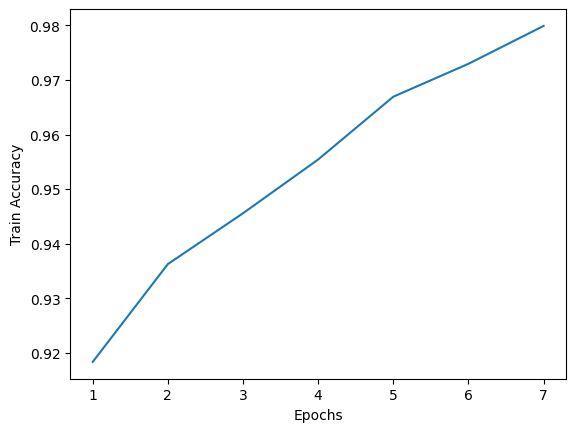

In [ ]:
# LSTM with fasttext
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/shared/model_task1_lstm_fasttext_ep_"
model = LSTM_model(300, 566, 28, fasttext_embedding_matrix, fasttext_word_to_ind)
generate_graph(model, sm_name, 7, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 0)

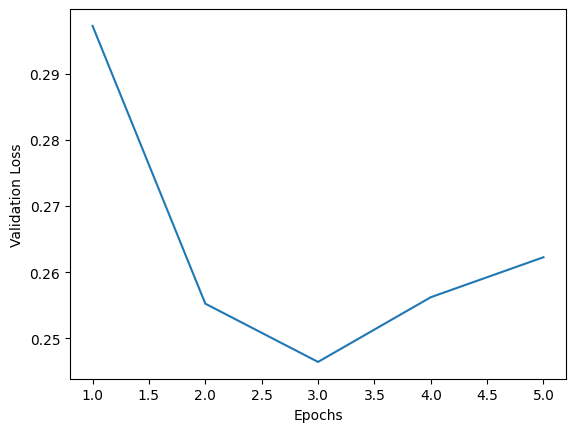

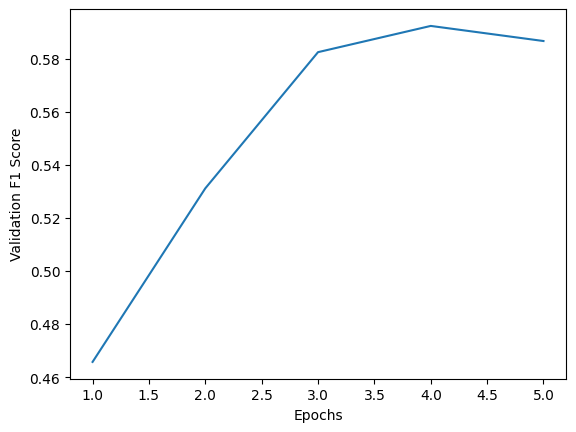

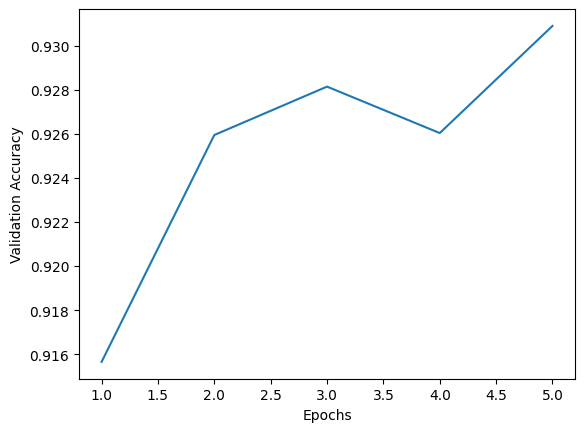

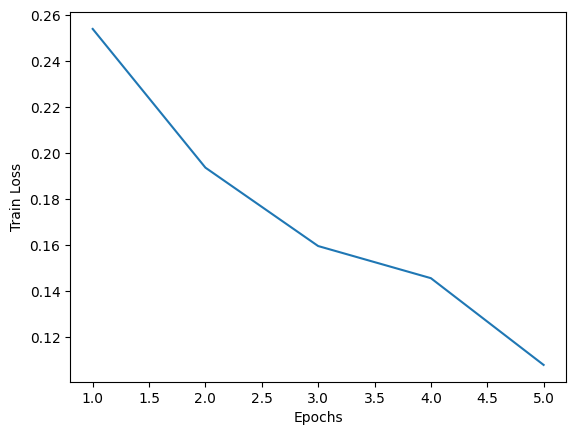

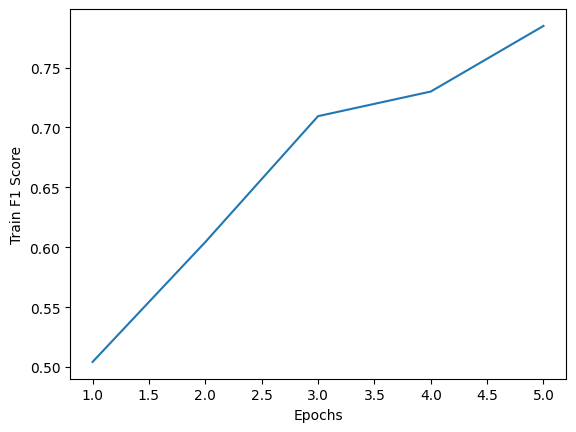

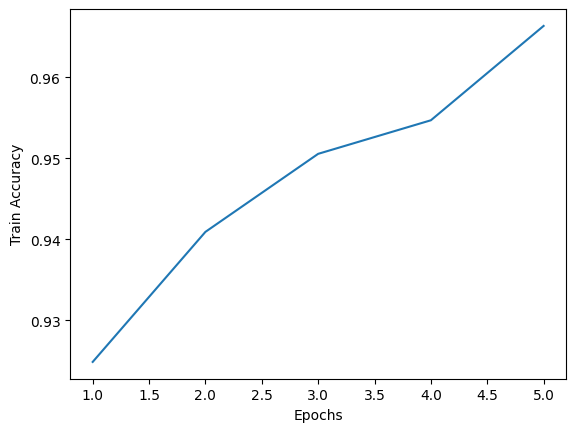

In [ ]:
# GRU with fasttext
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/fasttext/model_task1_gru_fasttext_ep_"
model = GRU_model(300, 566, 28, fasttext_embedding_matrix, fasttext_word_to_ind)
generate_graph(model, sm_name, 5, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), 0)

# **Performance On Test Data**

In [ ]:
print("RNN With Word2Vec")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/model_1_ep_9.pth"
model = RNN_model(300, 566, 28, word2vec_embedding_matrix, word2vec_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())

print("\nLSTM With Word2Vec")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/model_task1_lstm_ep_12.pth"
model = LSTM_model(300, 566, 28, word2vec_embedding_matrix, word2vec_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())

print("\nGRU With Word2Vec")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/model_task1_gru_ep_3.pth"
model = GRU_model(300, 566, 28, word2vec_embedding_matrix, word2vec_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())



RNN With Word2Vec
Test Accuracy: 0.8835037987973097 
F1-Score: 0.3358545605920529

LSTM With Word2Vec
Test Accuracy: 0.931873408323277 
F1-Score: 0.5895534842706347

GRU With Word2Vec
Test Accuracy: 0.9257206621468623 
F1-Score: 0.5879560816804817


In [ ]:
print("RNN With Glove")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/glove/glovemodel_rnn_ep_1.pth"
model = RNN_model(300, 566, 28, glove_embedding_matrix, glove_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())

print("\nLSTM With Glove")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/glove/model_task1_lstm_glove_ep_3.pth"
model = LSTM_model(300, 566, 28, glove_embedding_matrix, glove_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())

print("\nGRU With Glove")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/shared/t1_glovemodel_task1_gru_glove_ep_2.pth"
model = GRU_model(300, 566, 28, glove_embedding_matrix, glove_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())

RNN With Glove
Test Accuracy: 0.889328644173935 
Test F1-Score: 0.3810390361517919

LSTM With Glove
Test Accuracy: 0.9375458128464835 
Test F1-Score: 0.6290005081362111

GRU With Glove
Test Accuracy: 0.9296084373016981 
Test F1-Score: 0.6201986507688532


In [ ]:
print("RNN With Fasttext")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/shared/model_rnn_fasttext_ep_6.pth"
model = RNN_model(300, 566, 28, fasttext_embedding_matrix, fasttext_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())

print("\nLSTM With Fasttext")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/shared/model_task1_lstm_fasttext_ep_6.pth"
model = LSTM_model(300, 566, 28, fasttext_embedding_matrix, fasttext_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())

print("\nGRU With Fasttest")
sm_name = "/content/drive/MyDrive/Colab_data/NLP_AS2/Task1/model_checkpoints/fasttext/model_task1_gru_fasttext_ep_3.pth"
model = GRU_model(300, 566, 28, fasttext_embedding_matrix, fasttext_word_to_ind)
load_model(model, optim.Adam(model.parameters()), sm_name)
test(model, nn.CrossEntropyLoss())

RNN With Fasttext
Test Accuracy: 0.867058902857093 
Test F1-Score: 0.23237239964298442

LSTM With Fasttext
Test Accuracy: 0.9324165705083384 
Test F1-Score: 0.5457268897202321

GRU With Fasttest
Test Accuracy: 0.9236873089622437 
Test F1-Score: 0.5611569072603063
